<a href="https://colab.research.google.com/github/okana2ki/hotel-analysis/blob/main/search_trend2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colabで開いたら、まず、↑上部の「ドライブにコピー」をクリックして下さい。このノートブックがGoogleドライブの [マイドライブ > Colab Notebooks] に保存され、その後加えた変更がそこに自動保存されるようになります。

# 可視化によるデータの把握

In [1]:
# まず、アップロードされたファイルの中身を読んで、その構造とデータを理解しよう。
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/MyDrive/Colab_files/sekitotaka.csv'
data = pd.read_csv(file_path)

# データフレームの構造を理解するために、データフレームの最初の数行を表示する。
data.head()


,nen,tuki,sekino,takatihob
0,2014,4,12,40
1,2014,5,17,79
2,2014,6,8,27
3,2014,7,16,33
4,2014,8,17,50


'sekino'（関之尾の滝の検索回数）の予測モデルの構築に先立って、まず、散布図行列を作成し、データの特徴をつかみます。

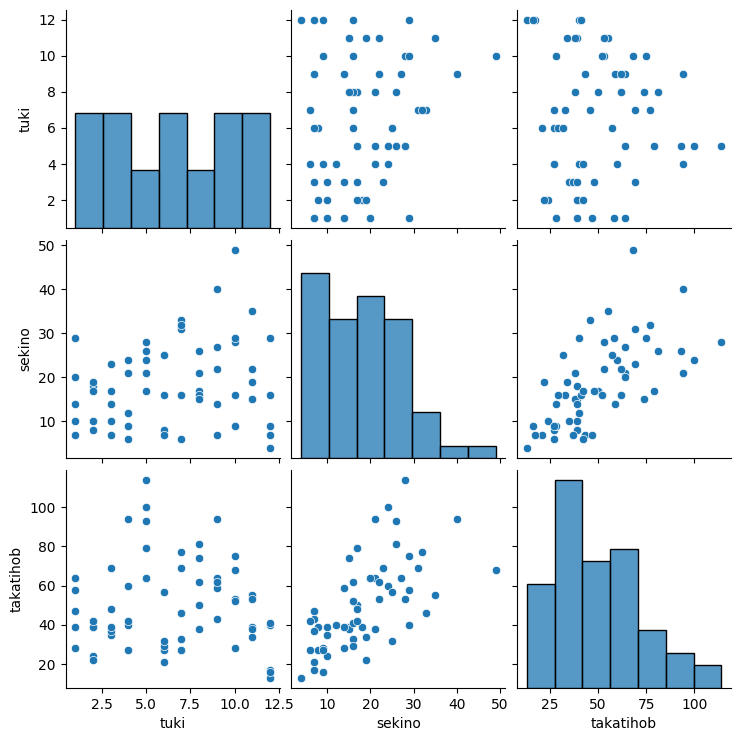

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting the relevant columns for the scatter plot matrix
columns_to_plot = data[['tuki', 'sekino', 'takatihob']]

# Create a pairplot (scatter plot matrix) for the selected columns
sns.pairplot(columns_to_plot)

# Show the plot
plt.show()

散布図行列を見て、'sekino'（関之尾の滝の検索回数）が'tuki'（月）と'takatihob'（高千穂牧場の検索回数）から予測できそうか見当をつけます。

また、'tuki'（月）と'takatihob'（高千穂牧場の検索回数）が互いに冗長でないかもチェックします。

# 重回帰分析による予測

## モデルの当てはまりの良さの評価

重回帰分析では、データがモデルにどれくらいよく当てはまっているかを決定係数で評価することが多いのですが、ここでは、他のモデルとの性能比較ができるように、**平均二乗誤差**（**MSE**: Mean Squared Error）で評価しましょう。

MSEは、『「予測値と正解値の差（＝誤差）」の二乗値』の平均です。

学習データに基づく予測モデルの評価では、**学習データ**に対する平均二乗誤差ではなく、初めて見た**テストデータ**に対する平均二乗誤差で評価します。学習データが共通に持つ性質をとらえて（それと同様の性質を持つが）初めて見たデータに応用できるかが知りたいからです。学習データ（教科書の問題とその答）を丸暗記しただけでは新しい問題に対応できません。内容を理解していて新しい問題に対応できるかどうかを見たいのです。テストデータを用いた評価は、実力テストみたいなものです。

テストデータの数が少ない（実力テストの問題数が少ない）と、たまたまできたり／できなかったりして、本当の実力と違う結果が出ることがあります。これをなるべく避けるために、テストデータの数を増やしたのと同じような効果がある方法（**交差検証（クロスバリデーション）**）が工夫されているので、ここでは、それを使います。

## 重回帰分析による予測と評価

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# データ中の関連する列の選択
X = data[['tuki', 'takatihob']]  # Features: tuki, takatihob
y = data['sekino']  # Target: sekino

# Creating a new Linear Regression model for cross-validation
model_cv = LinearRegression()

# Performing 10-fold cross-validation
# 'neg_mean_squared_error' is used to calculate MSE for each fold
scores = cross_val_score(model_cv, X, y, cv=10, scoring='neg_mean_squared_error')

# Converting scores to positive values (as they are negated by default)
mse_scores = -scores

# Calculating average MSE across all folds
average_mse = np.mean(mse_scores)

# Displaying the MSE for each fold and the average MSE
mse_scores, average_mse

(array([ 42.79721801,  30.16562878,  32.82000228,  34.59494688,
         61.37575103, 196.4565094 ,  68.18398009,  13.91875005,
         42.13338616,  32.6212111 ]),
 55.50673837828474)

# 特徴量エンジニアリング

「月」は、1から12までの値をとりますが、1月と12月は数字の大きさは大きく異なりますが、12月の次は1月ですから実は隣接している関係にあります。この隣接関係を反映した特徴量を新たに設計して追加してみましょう。12月と1月が隣であることが分かると予測しやすくなり、平均二乗誤差が減るかもしれません。このように特徴量を工夫することを特徴量エンジニアリングといいます。

時計の文字盤上の1から12までの配置は、12の次は1という性質を満たしているので、特徴量として良さそうに思えます。1から12を1次元の特徴量でなく、2次元の特徴量（平面上の座標値）とすることでこれが実現できます。具体的には、次のように新しい特徴量を作成します。

'tuki_cos' = cos(2π × 'tuki' / 12)

'tuki_sin' = sin(2π × 'tuki' / 12)

以下に tuki_cos と tuki_sin の散布図を示します。

In [ ]:
!pip install japanize-matplotlib

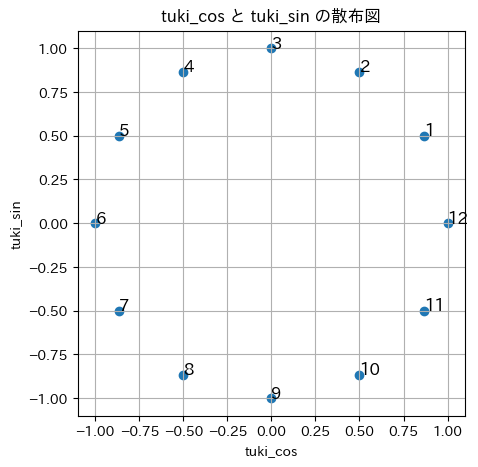

In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

# 月(tuki)の値を1から12までの整数とする
tuki_values = np.arange(1, 13)

# tuki_cosとtuki_sinの計算
tuki_cos = np.cos(2 * np.pi * tuki_values / 12)
tuki_sin = np.sin(2 * np.pi * tuki_values / 12)

# 散布図の作成
plt.figure(figsize=(5, 5))
plt.scatter(tuki_cos, tuki_sin)

# 各点に月(tuki)のラベルを付ける
for i, tuki in enumerate(tuki_values):
    plt.text(tuki_cos[i], tuki_sin[i], str(tuki), fontsize=12)

plt.title('tuki_cos と tuki_sin の散布図')
plt.xlabel('tuki_cos')
plt.ylabel('tuki_sin')
plt.grid(True)
plt.show()


データに'tuki_cos'と'tuki_sin'の列を追加し、新しいCSVファイルに格納


In [7]:
import numpy as np
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/MyDrive/Colab_files/sekitotaka.csv'
data = pd.read_csv(file_path)

# 'tuki_cos'と'tuki_sin'を計算し、dataにこの2列を追加
data['tuki_cos'] = np.cos(2 * np.pi * data['tuki'] / 12)
data['tuki_sin'] = np.sin(2 * np.pi * data['tuki'] / 12)

# 更新されたデータフレームを新しいCSVファイルに保存
updated_file_path = '/content/drive/MyDrive/Colab_files/sekitotaka_updated.csv'
data.to_csv(updated_file_path, index=False)

data.head()

,nen,tuki,sekino,takatihob,tuki_cos,tuki_sin
0,2014,4,12,40,-0.500000,8.660254e-01
1,2014,5,17,79,-0.866025,5.000000e-01
2,2014,6,8,27,-1.000000,1.224647e-16
3,2014,7,16,33,-0.866025,-5.000000e-01
4,2014,8,17,50,-0.500000,-8.660254e-01


## 可視化

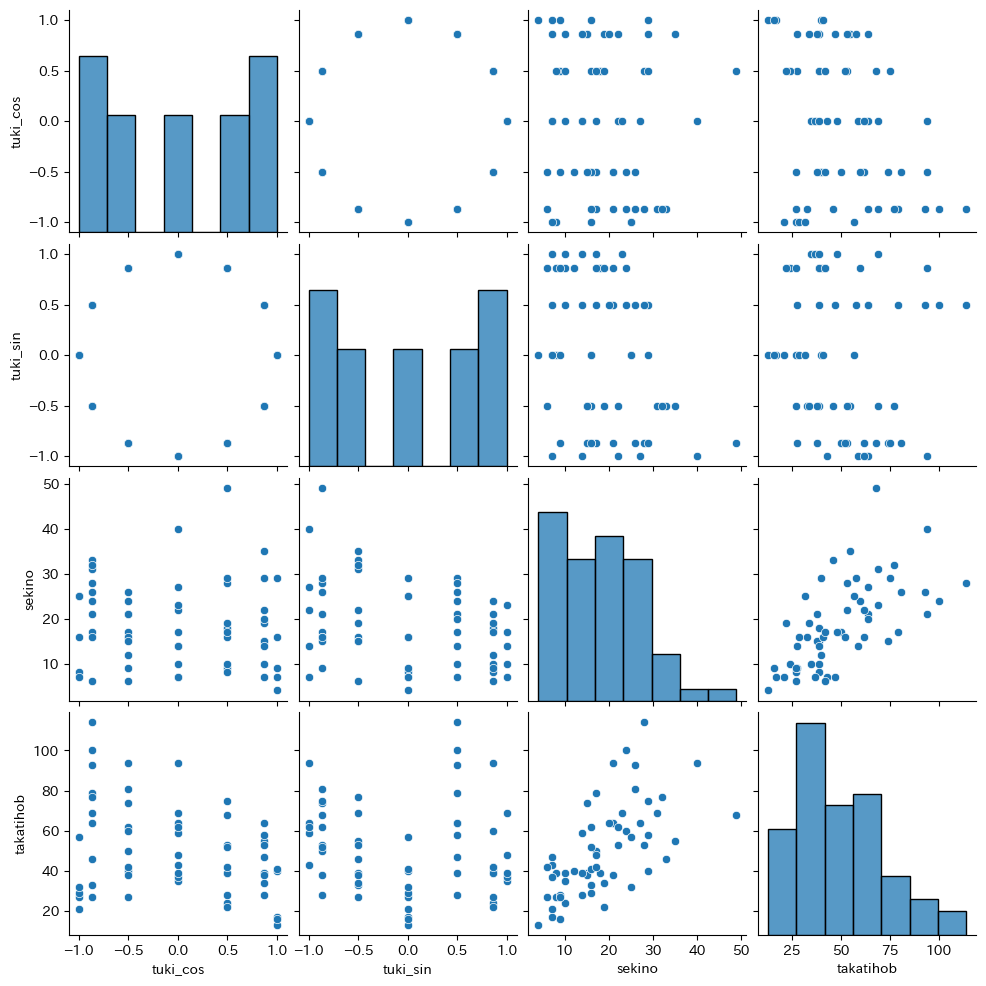

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting the relevant columns for the scatter plot matrix
columns_to_plot = data[['tuki_cos', 'tuki_sin', 'sekino', 'takatihob']]

# Create a pairplot (scatter plot matrix) for the selected columns
sns.pairplot(columns_to_plot)

# Show the plot
plt.show()

## 重回帰分析（特徴量エンジニアリング前後の比較）

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# データ中の関連する列の選択
X_original = data[['tuki', 'takatihob']]
X = data[['tuki_cos', 'tuki_sin', 'takatihob']]  # Features: tuki, takatihob
y = data['sekino']  # Target: sekino

# Creating a new Linear Regression model for cross-validation
model_cv = LinearRegression()

# Performing 10-fold cross-validation
# 'neg_mean_squared_error' is used to calculate MSE for each fold
scores_original = cross_val_score(model_cv, X_original, y, cv=10, scoring='neg_mean_squared_error')
scores = cross_val_score(model_cv, X, y, cv=10, scoring='neg_mean_squared_error')

# Converting scores to positive values (as they are negated by default)
mse_scores_original = -scores_original
mse_scores = -scores

# Calculating average MSE across all folds
average_mse_original = np.mean(mse_scores_original)
average_mse = np.mean(mse_scores)

# Displaying the MSE for each fold and the average MSE
print('before: ', mse_scores_original, average_mse_original)
print('after: ', mse_scores, average_mse)

before:  [ 42.79721801  30.16562878  32.82000228  34.59494688  61.37575103
 196.4565094   68.18398009  13.91875005  42.13338616  32.6212111 ] 55.50673837828474
after:  [ 46.4323825   36.98509387  25.139179    40.12797391  77.47281589
 216.66487408  81.74644089  15.01294967  34.39658547  20.90629451] 59.488458978977235


## 階層型ニューラルネットワークによる予測（特徴量エンジニアリング前後の比較）

階層型ニューラルネットワーク（特徴量エンジニアリング前；学習回数と隠れ層（１層だけ）のニューロン数をある程度調整）

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Creating a Feedforward Neural Network model
# Using a pipeline to standardize features before feeding them to the neural network
nn_model = make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=2250, hidden_layer_sizes=30))

# Performing 10-fold cross-validation on the original dataset with Neural Network
nn_scores_original = cross_val_score(nn_model, X_original, y, cv=10, scoring='neg_mean_squared_error')
nn_mse_scores_original = -nn_scores_original
nn_average_mse_original = np.mean(nn_mse_scores_original)

# Displaying the MSE for each fold and the average MSE
print('before: ', nn_mse_scores_original, nn_average_mse_original)

階層型ニューラルネットワーク（特徴量エンジニアリング後；学習回数と隠れ層（１層だけ）のニューロン数をある程度調整）

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Creating a Feedforward Neural Network model
# Using a pipeline to standardize features before feeding them to the neural network
nn_model = make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=3000, hidden_layer_sizes=40))

# Performing 10-fold cross-validation on the dataset with cyclically encoded month features using Neural Network
nn_scores = cross_val_score(nn_model, X, y, cv=10, scoring='neg_mean_squared_error')
nn_mse_scores = -nn_scores
nn_average_mse = np.mean(nn_mse_scores)

# Displaying the MSE for each fold and the average MSE
print('after: ', nn_mse_scores, nn_average_mse)

## （参考）その他のモデル（パラメータ調整は未実施）との比較

（参考）ランダムフォレストとグラディエントブースティング（特徴量エンジニアリング前；パラメータ調整なし）

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Creating RandomForest and GradientBoosting models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Performing 10-fold cross-validation on the original dataset with RandomForest
rf_scores_original = cross_val_score(rf_model, X_original, y, cv=10, scoring='neg_mean_squared_error')
rf_mse_scores_original = -rf_scores_original
rf_average_mse_original = np.mean(rf_mse_scores_original)

# Performing 10-fold cross-validation on the original dataset with GradientBoosting
gb_scores_original = cross_val_score(gb_model, X_original, y, cv=10, scoring='neg_mean_squared_error')
gb_mse_scores_original = -gb_scores_original
gb_average_mse_original = np.mean(gb_mse_scores_original)

rf_average_mse_original, gb_average_mse_original  # RandomForest MSE, GradientBoosting MSE

(59.201239583333326, 77.28762536968091)

（参考）ランダムフォレストとグラディエントブースティング（特徴量エンジニアリング後；パラメータ調整なし）

In [15]:
# Performing 10-fold cross-validation on the dataset with cyclically encoded month features using RandomForest
rf_scores = cross_val_score(rf_model, X, y, cv=10, scoring='neg_mean_squared_error')
rf_mse_scores = -rf_scores
rf_average_mse = np.mean(rf_mse_scores)

# Performing 10-fold cross-validation on the dataset with cyclically encoded month features using GradientBoosting
gb_scores = cross_val_score(gb_model, X, y, cv=10, scoring='neg_mean_squared_error')
gb_mse_scores = -gb_scores
gb_average_mse = np.mean(gb_mse_scores)

rf_average_mse, gb_average_mse  # RandomForest MSE, GradientBoosting MSE after feature engineering

(61.62318194444443, 80.3724448897617)

（参考）k最近傍法（特徴量エンジニアリング前後；パラメータ調整なし）

In [16]:
from sklearn.neighbors import KNeighborsRegressor

# Creating a KNeighborsRegressor model
knn_model = KNeighborsRegressor()

# Performing 10-fold cross-validation on the original dataset with KNeighborsRegressor
knn_scores_original = cross_val_score(knn_model, X_original, y, cv=10, scoring='neg_mean_squared_error')
knn_mse_scores_original = -knn_scores_original
knn_average_mse_original = np.mean(knn_mse_scores_original)

# Performing 10-fold cross-validation on the dataset with cyclically encoded month features using KNeighborsRegressor
knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='neg_mean_squared_error')
knn_mse_scores = -knn_scores
knn_average_mse = np.mean(knn_mse_scores)

knn_average_mse_original, knn_average_mse  # KNeighborsRegressor MSE before and after feature engineering

(69.112, 68.77000000000001)